In [1]:
import math
import multiprocessing
import os
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np

import modplot
import utils

In [2]:
save = True

# trigger names
all_trig_names = ['HLT_Jet30', 'HLT_Jet60', 'HLT_Jet80', 'HLT_Jet110', 'HLT_Jet150', 
                  'HLT_Jet190', 'HLT_Jet240', 'HLT_Jet300', 'HLT_Jet370', 'HLT_Jet800',
                  'HLT_DiJetAve30', 'HLT_DiJetAve60', 'HLT_DiJetAve80', 'HLT_DiJetAve110', 'HLT_DiJetAve150', 
                  'HLT_DiJetAve190', 'HLT_DiJetAve240', 'HLT_DiJetAve300', 'HLT_DiJetAve370', 
                  'HLT_DiJetAve15U', 'HLT_DiJetAve30U', 'HLT_DiJetAve50U', 'HLT_DiJetAve70U',
                  'HLT_DiJetAve100U', 'HLT_DiJetAve140U', 'HLT_DiJetAve180U', 'HLT_DiJetAve300U',
                  'HLT_Jet240_CentralJet30_BTagIP', 'HLT_Jet270_CentralJet30_BTagIP', 'HLT_Jet370_NoJetID']

# single jet triggers
jet_trig_names = all_trig_names[:9]

# colors
trigger_colors = {'HLT_Jet30':  '#999999',
                  'HLT_Jet60':  '#f781bf',
                  'HLT_Jet80':  '#a65628',
                  'HLT_Jet110': '#99cc00',
                  'HLT_Jet150': '#ff7f00',
                  'HLT_Jet190': '#984ea3',
                  'HLT_Jet240': '#4daf4a',
                  'HLT_Jet300': '#377eb8',
                  'HLT_Jet370': '#e41a1c'}

In [3]:
# lumiblocks
lbs = np.load(os.path.join(utils.DATASET_PATHS['cms'], 'lumis/ValidatedLumiblocks.pickle'), allow_pickle=True)
rnlbs = sorted(lbs.keys())

In [4]:
# get some convenient arrays for later
times = np.asarray([lbs[rnlb]['time'] for rnlb in rnlbs])
rec_lumis = np.asarray([lbs[rnlb]['rec_lumi'] for rnlb in rnlbs])
nevs = np.asarray([lbs[rnlb]['nev'] for rnlb in rnlbs])

In [5]:
# dictionary to hold trigger info for each lumi block
trigs = {trig: {'nlb': 0, 'counts': [], 'prescales': []} for trig in all_trig_names}

# iterate over lumiblocks
for i,rnlb in enumerate(rnlbs):
    
    # get lumi block and determine if it has nonzero recorded luminosity
    lb = lbs[rnlb]
    has_rec_lumi = rec_lumis[i] > 0.
    
    # add inds lookup to lb
    lb['names2inds'] = {n: i for i,n in enumerate(lb['triggers'])}
    
    # iterate over trigger dictionary
    for name,cur_trig in trigs.items():
        
        # if valid and trigger was present
        if has_rec_lumi and name in lb['triggers']:
            
            # determine position of trigger in lumiblock
            i0 = lb['names2inds'][name]
            
            # append info
            cur_trig['nlb'] += 1
            cur_trig['counts'].append(lb['counts'][i0])
            cur_trig['prescales'].append(lb['prescales'][i0])
            
        # trigger was not present
        else:
            cur_trig['counts'].append(0)
            cur_trig['prescales'].append(-1)

# make counts and prescales into numpy arrays
for trig,cur_trig in trigs.items():
    cur_trig['counts'] = np.asarray(cur_trig['counts'])
    cur_trig['prescales'] = np.asarray(cur_trig['prescales'])

## Table 1

In [31]:
def make_table1(out=None):

    # format table 1
    table_1 = ['equals', 'cols', 'equals',
                 'HLT_Jet30', 'HLT_Jet60', 'HLT_Jet80', 'HLT_Jet110', 'HLT_Jet150', 
                 'HLT_Jet190', 'HLT_Jet240', 'HLT_Jet300', 'HLT_Jet370', 'HLT_Jet800',
               'hline',
                 'HLT_DiJetAve30', 'HLT_DiJetAve60', 'HLT_DiJetAve80', 'HLT_DiJetAve110', 'HLT_DiJetAve150', 
                 'HLT_DiJetAve190', 'HLT_DiJetAve240', 'HLT_DiJetAve300', 'HLT_DiJetAve370', 
               'hline',
                 'HLT_DiJetAve15U', 'HLT_DiJetAve30U', 'HLT_DiJetAve50U', 'HLT_DiJetAve70U',
                 'HLT_DiJetAve100U', 'HLT_DiJetAve140U', 'HLT_DiJetAve180U', 'HLT_DiJetAve300U',
               'hline',
                 'HLT_Jet240_CentralJet30_BTagIP', 'HLT_Jet270_CentralJet30_BTagIP', 'HLT_Jet370_NoJetID',
               'equals']

    leff_dict = {}
    for name in table_1:
        if name == 'hline':
            print(100*'-', file=out)
        elif name == 'equals':
            print(100*'=', file=out)
        elif name == 'cols':
            cols = ('Trigger Name', 'LBs', 'Events', 'Fireds', 'L_eff [nb^-1]', '<p^trig>', 'sigma_eff [nb]')
            print('{:30}{:>10}{:>10}{:>9}{:>15}{:>10}{:>16}'.format(*cols), file=out)
        else:
            cur_trig = trigs[name]

            # get mask for when trigger is present
            mask = (cur_trig['prescales'] > 0)

            # add effective luminosity information (in 1/nb) per lumiblock to trigger dictionary 
            cur_trig['leffs'] = rec_lumis[mask]/cur_trig['prescales'][mask]/10**3

            # total effective luminosity
            leff = np.sum(cur_trig['leffs'])
            leff_dict[name] = leff

            # average prescale
            pavg = np.sum(rec_lumis[mask])/leff/10**3

            # number fired
            fired = int(np.sum(cur_trig['counts']))

            # format printing
            vals = (name, cur_trig['nlb'], nevs[mask].sum(), fired, leff, pavg, fired/leff)
            print('{:30}{:>10}{:>10}{:>9}{:>15.3f}{:>10.1f}{:>16.3f}'.format(*vals), file=out)
           
    if out is None:
        return leff_dict

# for printing here
leff_dict = make_table1()
leff_dict['units'] = 'nb^-1'

if save:
    with open('../plots/Triggers/Table_1.txt', 'w') as f:
        make_table1(out=f)
        
    leff_filepath = os.path.join(utils.DATASET_PATHS['cms'], 'EffectiveLuminositiesByTrigger.pickle')
    with open(leff_filepath, 'wb') as f:
        pickle.dump(leff_dict, f)

Trigger Name                         LBs    Events   Fireds  L_eff [nb^-1]  <p^trig>  sigma_eff [nb]
HLT_Jet30                         109196  26254892  1884768         12.567  185672.6      149981.925
HLT_Jet60                         109196  26254892  1829490        293.986    7936.7        6223.060
HLT_Jet80                         102304  24742482  1512638        901.352    2293.8        1678.188
HLT_Jet110                        109196  26254892  2212878       6172.430     378.0         358.510
HLT_Jet150                        102304  24742482  2616716      33521.114      61.7          78.062
HLT_Jet190                        109196  26254892  2715282     114843.687      20.3          23.643
HLT_Jet240                        109196  26254892  2806220     392659.479       5.9           7.147
HLT_Jet300                         98462  22788815  4616184    2284792.618       1.0           2.020
HLT_Jet370                        109196  26254892  1514305    2333280.071       1.0       

### Time Order Luminosity Blocks

In [7]:
# iterate over triggers
for name,cur_trig in trigs.items():
    
    # mask of when trigger was present
    mask = (cur_trig['prescales'] > 0)
    
    # time sorting of lumi blocks
    time_argsort = np.argsort(times[mask])
    
    # effective luminosities ordered by time
    cur_trig['leffs_ordered'] = cur_trig['leffs'][time_argsort]
    
    # effective cross sections ordered by time 
    cur_trig['sigmaeffs_ordered'] = cur_trig['counts'][mask][time_argsort]/(cur_trig['leffs_ordered'] + 10**-30)
    
    # time ordered indices of blocks that are present
    cur_trig['indices'] = np.arange(len(mask))[mask]

## Effective Luminosity Plot

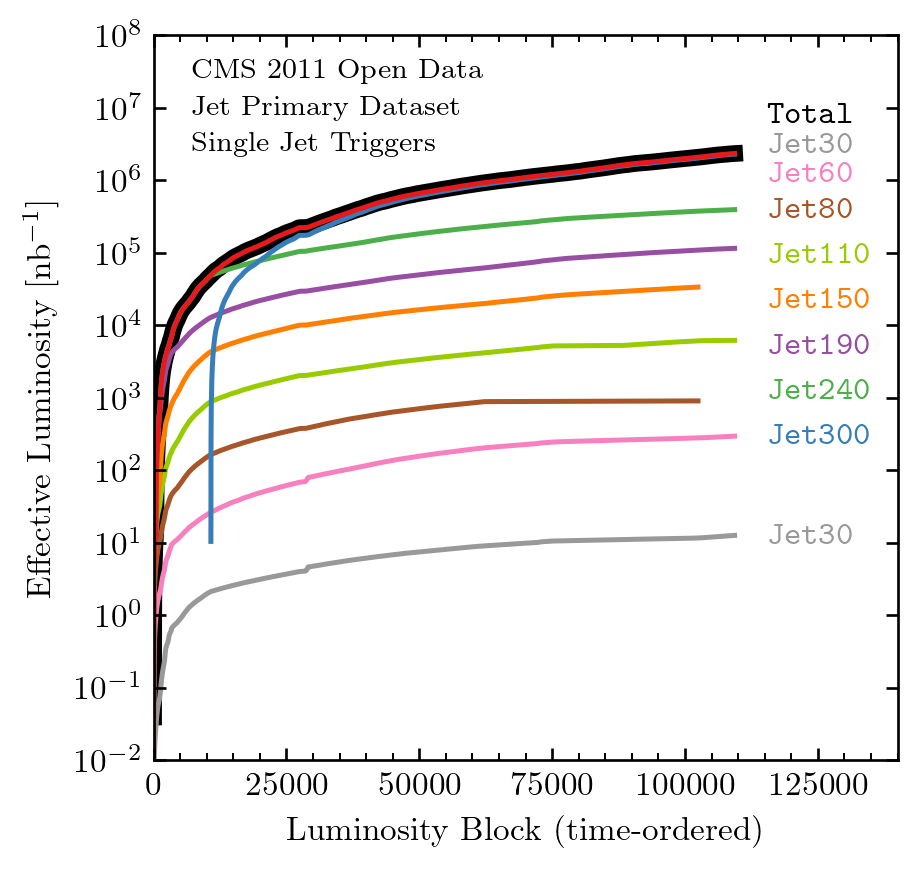

In [8]:
fig, axes = modplot.axes(ratio_plot=False, 
                         xlabel='Luminosity Block (time-ordered)', 
                         ylabel=r'Effective Luminosity [nb$^{-1}$]',
                         xlim=(0, 140000),
                         xtick_step=25000)
ax = axes[0]

ax.set_yscale('log')
ax.set_ylim(10**-2, 10**8)
ax.set_yticks(10.**np.arange(-2, 9))

# iterate over single jet triggers
for i,name in enumerate(jet_trig_names[::-1]):
    cur_trig = trigs[name]
    
    # plot cumulative effective luminsoity
    ax.plot(cur_trig['indices'], np.cumsum(cur_trig['leffs_ordered']), '-', zorder=-i,
             color=trigger_colors[name])

cur_trig = trigs['HLT_Jet370']
ax.plot(cur_trig['indices'], np.cumsum(cur_trig['leffs_ordered']), '-', lw=5, zorder=-20, color='black')

x = 0.825
modplot.stamp(x, 0.89, line_0=r'\tt Total', line_1=None, ax=ax,
              textops_update={'color': 'black', 'fontsize': 10})

y, delta_y = 0.85, 0.04
for i,name in enumerate(jet_trig_names[:2]):
    modplot.stamp(x, y - i*delta_y, line_0=r'\tt {}'.format(name[4:]), line_1=None, ax=ax,
                  textops_update={'color': trigger_colors[name], 'fontsize': 10})
    
y, delta_y = 0.76, 0.0625
for i,name in enumerate(jet_trig_names[2:-1]):
    modplot.stamp(x, y - i*delta_y, line_0=r'\tt {}'.format(name[4:]), line_1=None, ax=ax,
                  textops_update={'color': trigger_colors[name], 'fontsize': 10})
    
modplot.stamp(x, 0.31, line_0=r'\tt Jet30', line_1=None, ax=ax,
                  textops_update={'color': trigger_colors['HLT_Jet30'], 'fontsize': 10})

modplot.stamp(0.05, 0.95, delta_y=0.05,
              line_0='CMS 2011 Open Data', 
              line_1='Jet Primary Dataset', 
              line_2='Single Jet Triggers')

if save:
    modplot.save(fig, 'CMS_EffectiveLuminositiesByLumiBlock', 
                 tx=45, ty=252.5, out_plots_dir='../plots/Triggers')

fig.show()

## Effective Cross Section Plot

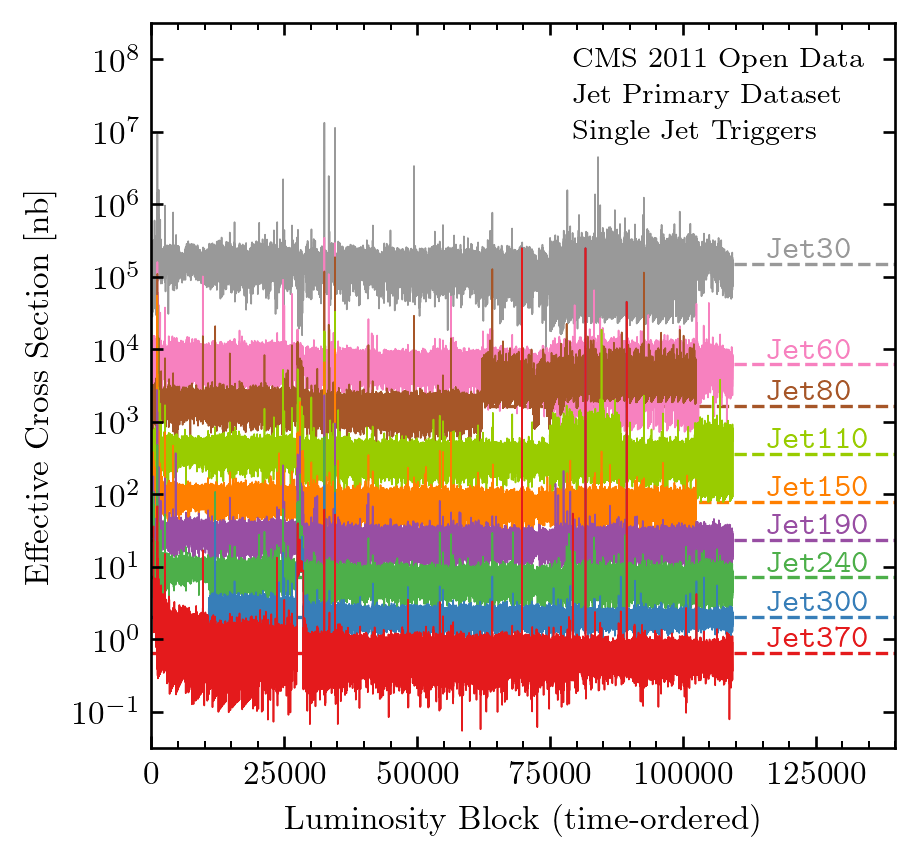

In [9]:
fig, axes = modplot.axes(ratio_plot=False, 
                         xlabel='Luminosity Block (time-ordered)',
                         ylabel='Effective Cross Section [nb]',
                         xlim=(0, 140000),
                         xtick_step=25000)

ax = axes[0]

ax.set_yscale('log')
ax.set_ylim(10**-1.5, 10**8.5)
ax.set_yticks(10.**np.arange(-1, 9))

# iterate over single jet triggers
for i,name in enumerate(jet_trig_names[::-1]):
    cur_trig = trigs[name]
    color = trigger_colors[name]
    
    # non-zero make
    nz_mask = (cur_trig['sigmaeffs_ordered'] > 0)
    
    # plot average effective cross section
    avg_eff_xs = np.sum(cur_trig['counts'])/np.sum(cur_trig['leffs'])
    ax.plot([0, 140000], 2*[avg_eff_xs], '--', lw=1, color=color, zorder=-20)
    
    # plot effective cross section by lumi block
    ax.plot(cur_trig['indices'][nz_mask], cur_trig['sigmaeffs_ordered'][nz_mask], '-', lw=0.5, 
             color=color, zorder=-i)
    
    # jet label
    ax.text(115500, avg_eff_xs*1.6, r'\tt {}'.format(name[4:]), 
            horizontalalignment='left', verticalalignment='center', fontsize=10, color=color)

modplot.stamp(0.565, 0.95, delta_y=0.05,
              line_0='CMS 2011 Open Data', 
              line_1='Jet Primary Dataset', 
              line_2='Single Jet Triggers')

if save:
    modplot.save(fig, 'CMS_EffectiveCrossSectionByLumiBlock', 
                 tx=44.3, ty=252.5, out_plots_dir='../plots/Triggers')
    
fig.show()

## Single Jet Triggers by pT

In [14]:
def triggers_by_pt(filepath):
    
    # containers
    fireds, prescales, jet_pts = [], [], []
    
    # load file
    f = np.load(filepath, allow_pickle=True)
    
    # get lumiblocks for this file
    f_lbs = f['lbs']
    for lb in f_lbs:
        lb_triggers, lb_prescales = lb['triggers'], lb['prescales']
        
        # the indices where the jet triggers are for this lumi block, -1 if not present
        lb['jtn_inds'] = np.asarray([lb_triggers.index(name) if name in lb_triggers else -1 
                                     for name in jet_trig_names])
        
        # the prescales for the jet triggers in this lumi block, -1 if not present
        lb['jtn_prescales'] = np.asarray([lb_prescales[jtn_i] if jtn_i != -1 else -1 
                                          for jtn_i in lb['jtn_inds']])
        
        # rnlb
        lb['rnlb'] = (lb['rn'], lb['lb'])
    
    # iterate over events in file
    for lb_i,ak5s,ftrig in zip(f['lbs_i'], f['ak5s'], f['ftrigs']):
        
        # skip if no jets
        if not len(ak5s):
            continue
        
        # get lumiblock for this event
        lb = f_lbs[lb_i]
        
        # skip if invalid
        if lb['rnlb'] not in lbs or lbs[lb['rnlb']]['rec_lumi'] == 0.:
            continue
        
        # apply JECs
        pts_corrected = ak5s[:,1] * ak5s[:,5]
        argsort = np.argsort(pts_corrected)[::-1]
        
        # iterate over hardest two jets
        n = 0
        for i in argsort[:1]:
            
            # get jet
            ak5 = ak5s[i]
            
            # get proper pt and eta
            pt = pts_corrected[i]

            # impose medium quality
            if ak5[13] < 2:
                continue

            # append jet pt
            jet_pts.append(pt)
            
            # increase counter
            n += 1
            
        # if we got any jets from this event
        if n > 0:
            
            # determine if triggers fired
            ak5_fireds = np.isin(lb['jtn_inds'], ftrig, assume_unique=True)

            # append fireds and prescales the correct number of times
            if n == 1:
                fireds.append(ak5_fireds)
                prescales.append(lb['jtn_prescales'])
            elif n == 2:
                fireds.extend(2*[ak5_fireds])
                prescales.extend(2*[lb['jtn_prescales']])
                
    return fireds, prescales, jet_pts

# iterate over files containing jet info
start = time.time()
filepaths = utils.get_filenames(subdir='pickle', include_path=True, must_include='noparticles')

# containers
fireds, prescales, jet_pts = [], [], []
with multiprocessing.Pool(processes=None) as pool:
    for i,rs in enumerate(pool.imap_unordered(triggers_by_pt, filepaths, chunksize=1)):
        if (i+1) % 100 == 0:
            print('[{}/{}] files processed in {:.3f}s'.format(i+1, len(filepaths), time.time() - start))
            
        fireds.extend(rs[0])
        prescales.extend(rs[1])
        jet_pts.extend(rs[2])

# make numpy arrays
fireds = np.asarray(fireds, dtype=bool)
prescales = np.asarray(prescales, dtype=int)
jet_pts = np.asarray(jet_pts, dtype=float)

# save numpy arrays
if save:
    fp = os.path.join(utils.DATASET_PATHS['cms'], 'plotdata/TriggersByPtHardestJet.npz')
    print('Saved to', fp)
    np.savez_compressed(fp, fireds=fireds, prescales=prescales, jet_pts=jet_pts)

[50/1223] files processed in 7.266s
[100/1223] files processed in 9.805s
[150/1223] files processed in 12.145s
[200/1223] files processed in 14.732s
[250/1223] files processed in 17.182s
[300/1223] files processed in 19.648s
[350/1223] files processed in 22.083s
[400/1223] files processed in 24.561s
[450/1223] files processed in 26.958s
[500/1223] files processed in 29.520s
[550/1223] files processed in 32.232s
[600/1223] files processed in 35.107s
[650/1223] files processed in 38.498s
[700/1223] files processed in 41.356s
[750/1223] files processed in 43.957s
[800/1223] files processed in 46.556s
[850/1223] files processed in 48.947s
[900/1223] files processed in 51.250s
[950/1223] files processed in 53.662s
[1000/1223] files processed in 56.192s
[1050/1223] files processed in 58.564s
[1100/1223] files processed in 60.931s
[1150/1223] files processed in 63.484s
[1200/1223] files processed in 66.109s
Saved to /disk0/CMS2011AJets/JetPrimaryDataset/plotdata/TriggersByPtHardestJet.npz


In [ ]:
def extract_trigger_info(filepath):
    
    # containers
    fireds, prescales, jet_pts = [], [], []
    
    # load file
    f = np.load(filepath, allow_pickle=True)
    
    # iterate over events in file
    for lb_i,ak5s,ftrig in zip(f['lbs_i'], f['ak5s'], f['ftrigs']):
        
        # skip if no jets
        if not len(ak5s):
            continue
        
        # apply JECs
        pts_corrected = ak5s[:,1] * ak5s[:,5]
        argsort = np.argsort(pts_corrected)[::-1]
        
        # iterate over hardest two jets
        n = 0
        for i in argsort[:2]:
            
            # get jet
            ak5 = ak5s[i]
            
            # get proper pt and eta
            pt = pts_corrected[i]

            # impose medium quality
            if ak5[13] < 2:
                continue

            # append jet pt
            jet_pts.append(pt)
            
            # increase counter
            n += 1
                
    return np.asarray(jet_pts, dtype=float)

###############################################################################################################

# get all filepaths for sim datasets
sim_filepaths = utils.get_sim_filenames_dict(subdir='pickle', include_path=True, must_include='noparticles')

# iterate over sim datasets
jet_pts = {}
for ptmin in sim_filepaths.keys():

    # iterate over files containing jet info
    start = time.time()
    with multiprocessing.Pool(processes=None) as pool:
        
        # parallelize extracting the trigger info
        results = pool.map(extract_trigger_info, sim_filepaths[ptmin])
        
        # form containers
        jet_pts[ptmin] = np.concatenate(tuple(results))
        
    # print progress
    print('Finished with ptmin {} in {:.3f}s'.format(ptmin, time.time() - start))
    
if save:
    with open(os.path.join(utils.DATASET_PATHS['sim'], 'plotdata', 'JetPtsByDataset.pickle'), 'wb') as f:
        pickle.dump(jet_pts, f)

In [ ]:
# pt bins
bins = np.linspace(0, 600, 61)
start = time.time()

# get bin indices
pt_bin_inds = np.digitize(jet_pts, bins=bins)
print('Digitized in {:.3f}s'.format(time.time() - start))

def make_trig_turnon_curve(i, reg=10**-30):
    
    # indices for low and high triggers
    low, high = i, i+1
    
    # masks for which jets had the low and high trigger firing
    low_fired_mask, high_fired_mask = fireds[:,low], fireds[:,high]
    
    # mask for when the high trigger was present
    high_present_mask = (prescales[:,high] > 0.)
    
    # if trig is one of the ones with common L1, use GCD formula, else 1/prescale_high
    if jet_trig_names[high] in {'HLT_Jet190', 'HLT_Jet240', 'HLT_Jet300', 'HLT_Jet370'}:
        weights = np.asarray([math.gcd(h,l)/h for h,l in zip(prescales[:,high], prescales[:,low])])
    else:
        weights = 1/prescales[:,high]
        
    # iterate over bins:
    trig_turnon = []
    for bin_i in range(1, len(bins)):
        
        # get bin mask
        bin_mask = (pt_bin_inds == bin_i)
        
        # get quantities for this bin
        low_fired_bin_i = low_fired_mask[bin_mask]
        high_fired_bin_i = high_fired_mask[bin_mask]
        high_present_bin_i = high_present_mask[bin_mask]
        weights_bin_i = weights[bin_mask]
        
        # construct masks where low was present and high trigger did and did not fire
        yes_mask = low_fired_bin_i & high_fired_bin_i
        no_mask = low_fired_bin_i & high_present_bin_i & ~high_fired_bin_i
        
        # construct quantities
        Y = np.count_nonzero(yes_mask)
        Yw, Nw = np.sum(weights_bin_i[yes_mask]), np.sum(weights_bin_i[no_mask])
        Yww, Nww = np.sum(weights_bin_i[yes_mask]**2), np.sum(weights_bin_i[no_mask]**2)
        
        # get the central value
        rate = Y/(Yw + Nw + reg)
        
        # get the error
        err = Y/(Yw + Nw + reg)**2*np.sqrt(Yww + Nww + (Nw**2 - Yw**2)/(Y + reg))
        
        # append answer
        trig_turnon.append([rate, err])

    # return turnon curve
    return np.asarray(trig_turnon, dtype=float)

ncurves = len(jet_trig_names) - 1
with multiprocessing.Pool(ncurves) as pool:
    turnon_curves = pool.map(make_trig_turnon_curve, range(ncurves), chunksize=1)
    print('Computed curves in {:.3f}s'.format(time.time() - start))
    
trig_turnons = {name: turnon_curves[i] for i,name in enumerate(jet_trig_names[1:])}

if save:
    fp = os.path.join(utils.DATASET_PATHS['cms'], 'plotdata', 'TriggerTurnOnHardestJet.npz')
    print('Saved to', fp)
    np.savez(fp, bins=bins, **trig_turnons)

## Effective Cross Section by pT

In [23]:
# load in saved trigger info
trigsbypt = np.load(os.path.join(utils.DATASET_PATHS['cms'], 'plotdata/TriggersByPtHardestJet.npz'))
fireds, prescales, jet_pts = trigsbypt['fireds'], trigsbypt['prescales'], trigsbypt['jet_pts']

In [24]:
bins = np.linspace(0, 800, 81)
midbins = (bins[1:] + bins[:-1])/2
binwidth = bins[1] - bins[0]

eff_xs_hists = {}
for i,name in enumerate(jet_trig_names):
    hist, errs, bins = modplot.calc_hist(jet_pts[fireds[:,i]], bins=bins, density=False)
    eff_xs_hists[name] = (hist, errs)

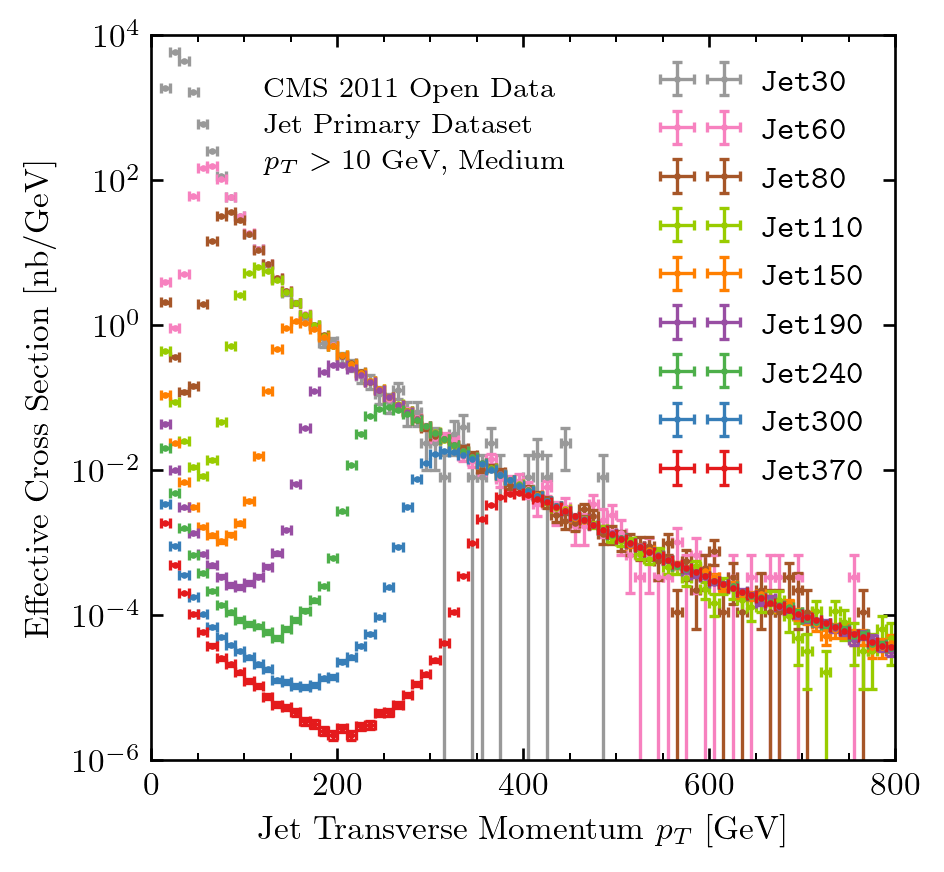

In [25]:
fig, axes = modplot.axes(ratio_plot=False, 
                         xlim=(min(bins), max(bins)), ylim=(10**-6, 10**4),
                         xlabel=r'Jet Transverse Momentum $p_T$ [GeV]',
                         ylabel='Effective Cross Section [nb/GeV]')
ax = axes[0]
ax.set_yscale('log')

for i,name in enumerate(jet_trig_names):
    hist, errs = eff_xs_hists[name]
    
    c = np.sum(trigs[name]['leffs'])*binwidth
    
    ax.errorbar(midbins, hist/c, xerr=binwidth/2, yerr=errs/c,
                marker='o', ms=1, ls='none', elinewidth=1, capthick=1, capsize=1.5,
                label=r'\tt {}'.format(name[4:]), color=trigger_colors[name])
    
# legend
ax.legend(loc='upper right', frameon=False, ncol=1, numpoints=2)

# stamp
modplot.stamp(0.15, 0.925, delta_y=0.05,
              line_0='CMS 2011 Open Data', 
              line_1='Jet Primary Dataset', 
              line_2=r'$p_T>10$ GeV, Medium')

if save:
    modplot.save(fig, 'CMS_EffectiveCrossSectionByPtHardestJet', 
                 tx=44.5, ty=252, out_plots_dir='../plots/Triggers')

fig.show()

## SIM Effective Cross Section by pT

In [32]:
jet_pts = np.load(os.path.join(utils.DATASET_PATHS['sim'], 'plotdata', 'JetPtsByDataset.pickle'), 
                  allow_pickle=True)

In [33]:
bins = np.linspace(0, 2500, 101)
midbins = (bins[1:] + bins[:-1])/2
binwidth = bins[1] - bins[0]

sim_xs = np.load(os.path.join(utils.DATASET_PATHS['sim'], 'CrossSections.pickle'), allow_pickle=True)

eff_xs_hists = {}
for ptmin,pts in jet_pts.items():
    hist, errs, bins = modplot.calc_hist(pts, bins=bins, density=False)
    
    # to convert counts to nb
    c = sim_xs[ptmin]['xs']/sim_xs[ptmin]['nev']/binwidth/10**3
    
    eff_xs_hists[ptmin] = (hist*c, errs*c)

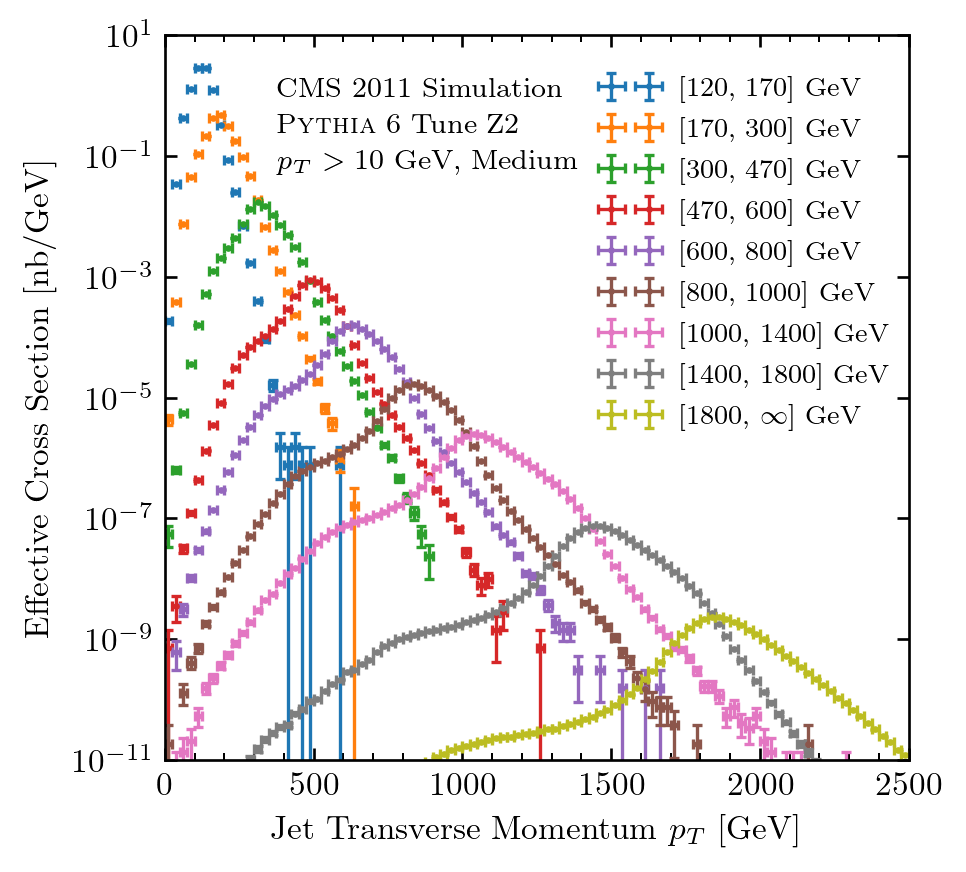

In [39]:
fig, axes = modplot.axes(ratio_plot=False, 
                         xlim=(min(bins), max(bins)), ylim=(10**-11, 10**1),
                         xlabel=r'Jet Transverse Momentum $p_T$ [GeV]',
                         ylabel='Effective Cross Section [nb/GeV]')
ax = axes[0]
ax.set_yscale('log')

ptmins = list(eff_xs_hists.keys()) + [r'$\infty$']
for i,(hist, errs) in enumerate(eff_xs_hists.values()):
    ax.errorbar(midbins, hist, xerr=binwidth/2, yerr=errs,
                marker='o', ms=1, ls='none', elinewidth=1, capthick=1, capsize=1.5,
                label=r'[{}, {}] GeV'.format(ptmins[i], ptmins[i+1]))
    
# legend
ax.legend(loc=(0.575, 0.44), frameon=False, ncol=1, numpoints=2, fontsize=8)

# stamp
modplot.stamp(0.15, 0.925, delta_y=0.05,
              line_0='CMS 2011 Simulation', 
              line_1=r'\textsc{Pythia} 6 Tune Z2', 
              line_2=r'$p_T>10$ GeV, Medium')

if save:
    modplot.save(fig, 'SIM_EffectiveCrossSectionByPt', tx=48.5, ty=252, out_plots_dir='../plots/Triggers')

fig.show()

## Trigger Turn On by pT

In [27]:
# load saved turn on curves
f = np.load(os.path.join(utils.DATASET_PATHS['cms'], 'plotdata', 'TriggerTurnOnHardestJet.npz'))
trig_turnons = {name: f[name] for name in jet_trig_names[1:]}
bins = f['bins']

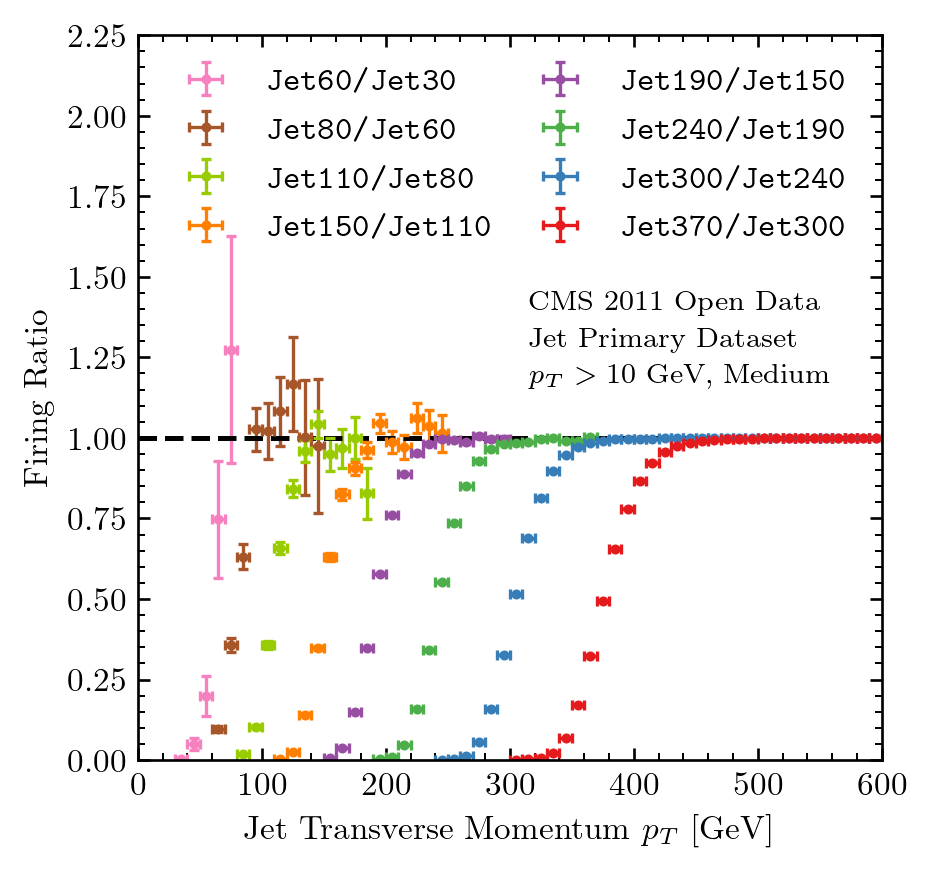

In [28]:
# middle of the pt bins
midbins = (bins[1:] + bins[:-1])/2

# range to plot for given trigger
xrange = {'HLT_Jet60':  (30, 80), 'HLT_Jet80':  (60, 150), 
          'HLT_Jet110': (80, 190), 'HLT_Jet150': (110, 250), 
          'HLT_Jet190': (150, 300), 'HLT_Jet240': (190, 370), 
          'HLT_Jet300': (240, max(bins)), 'HLT_Jet370': (300, max(bins))}

fig, axes = modplot.axes(ratio_plot=False, 
                         xlim=(min(bins), max(bins)), ylim=(0, 2.25),
                         xlabel=r'Jet Transverse Momentum $p_T$ [GeV]',
                         ylabel='Firing Ratio')
ax = axes[0]

# plot horizontal line
ax.plot([min(bins), max(bins)], [1, 1], '--', color='black', lw=1.5)

# iterate over tirggers and plot them
for i,name in enumerate(jet_trig_names[1:]):
    mask = (xrange[name][0] <= midbins) & (midbins <= xrange[name][1])
    rates, errs = trig_turnons[name][mask,0], trig_turnons[name][mask,1]
    ax.errorbar(midbins[mask], rates, yerr=errs, xerr=(bins[1] - bins[0])/2, 
                marker='o', ms=2, ls='none', elinewidth=1, capthick=1, capsize=1.5,
                label=r'\tt {}/{}'.format(name[4:], jet_trig_names[i][4:]), color=trigger_colors[name])

# legend
ax.legend(loc='upper center', frameon=False, ncol=2, columnspacing=1)

# stamp
modplot.stamp(0.525, 0.63, delta_y=0.05,
              line_0='CMS 2011 Open Data', 
              line_1='Jet Primary Dataset', 
              line_2=r'$p_T>10$ GeV, Medium')

if save:
    modplot.save(fig, 'CMS_TriggerTurnOnHardestJet', 
                 tx=40.5, ty=252, out_plots_dir='../plots/Triggers')

fig.show()